# Стационарность

 

## Введение

- Ранее мы узнали, что временные ряды — это данные, которые измеряются через равные интервалы.
- Мы также узнали, что данные временных рядов можно разложить на три части: тренд, сезонность и остатки.
- Теперь мы углубимся в обсуждение важной концепции, называемой **стационарностью**.
- Четкое понимание этой концепции заложит основу, необходимую для понимания более сложных стратегий моделирования, которые мы представим позже.

В этой лекции мы рассмотрим
- Определение стационарности и примеры распространенных стационарных и нестационарных временных рядов.
- Как обнаружить стационарность.
- Наиболее распространенные способы преобразования нестационарных временных рядов в стационарные.

In [199]:
# Imports
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(0) # Reproducibility

---

## Стационарный временной ряд

### Почему стационарность важна?

- Стационарность является фундаментальным предположением во многих моделях прогнозирования временных рядов.
- Без нее многие базовые модели временных рядов сломались бы.
- Для преобразования нестационарного временного ряда в стационарный можно применять преобразования.
- Существуют продвинутые модели временных рядов, которые могут обрабатывать нестационарные данные (выходящие за рамки этой лекции).

### Что такое стационарность?

- 💡 Интуиция: временной ряд стационарен, когда нет никаких изменений в базовой системе, которая его генерирует.
- Далее мы определяем:
- Строгую стационарность.
- Слабую стационарность.
- Что нужно проверить на практике.

#### Строгая стационарность

- Стохастический процесс $X(t): t \in \mathcal{T}$ называется строго стационарным, если для всех $t_1, t_2, \dots, t_n \in \mathcal{T}$ и $h$ таких, что $t_1+h, t_2+h, \dots, t_n+h \in \mathcal{T}$, выполняется следующее:

$$\big(X(t_1),X(t_2), \dots, X(t_n)\big) \stackrel{\text{D}}{=} \big(X(t_1+h),X(t_2+h), \dots, X(t_n+h)\big)$$

- где $\stackrel{\text{D}}{=}$ указывает на то, что распределения равны.
- Проще говоря, совместное распределение любого набора наблюдений в серии остается неизменным независимо от времени проведения наблюдений.

- Строгую стационарность очень трудно проверить, особенно при ограниченном объеме данных.
- По этой причине проверяется *Слабая стационарность*.
  

#### Слабая стационарность

- Временной ряд $X$ является слабо стационарным, если:

1. Среднее значение постоянно во времени $\mathbb{E}[X(t)] = m, \;\; \forall t \in \mathcal{T}$
2. Дисперсия конечна $\mathbb{E}[X(t)^2] < \infty, \;\; \forall t \in \mathcal{T}$
3. Ковариация $X(t)$ и $X(t+h)$ зависит только от $h$, т. е. является инвариантной к сдвигу во времени.

- Строгая стационарность + условие 2 $\implies$ слабая стационарность

#### Что нужно проверить на практике.

1. Постоянное среднее (нет тренда).

2. Постоянная дисперсия (нет гетероскедастичности).

3. Постоянная структура автокорреляции.

4. Отсутствие периодической составляющей (✋ будьте осторожны)

- Среднее значение, дисперсия и периодическая составляющая (она же сезонность) должны быть знакомы из предыдущей лекции.
- Автокорреляция может быть незнакома.
- Давайте начнем с простого примера стационарного временного ряда.

- Давайте создадим полезную функцию для построения графиков.

In [200]:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

- Сначала мы создаем переменную `time`, которая определяет равномерно распределенные временные интервалы.
- Затем мы выберем значения из нормального распределения со средним значением 0 и стандартным отклонением 1.
- По сути, мы создаем белый шум, который является стационарным временным рядом, поскольку он демонстрирует все свойства, требуемые для стационарного временного ряда.

In [201]:
T = 200
time = np.arange(T)
stationary = np.random.normal(loc=0, scale=1.0, size=(T))

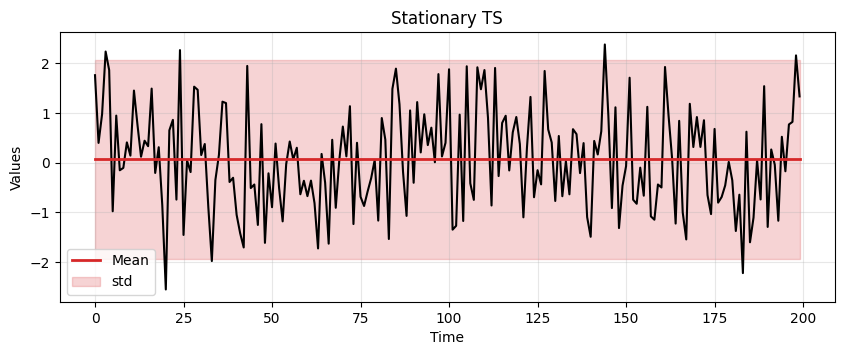

In [202]:
ax = run_sequence_plot(time, stationary, title="Stationary TS")
ax.plot(time, np.ones_like(time)*np.mean(stationary), linewidth=2, color='tab:red', label='Mean');
ax.fill_between(time, np.ones_like(time)*(stationary.mean()-1.96*stationary.std()),
                np.ones_like(time)*(stationary.mean()+1.96*stationary.std()),
                color='tab:red', alpha=0.2, label='std')
plt.legend();

- Мы можем легко проверить, что белый шум имеет постоянное среднее значение, постоянную дисперсию и не имеет периодичности.
- А как насчет автокорреляции?

#### Автокорреляция
- Автокорреляция измеряет, насколько текущее измерение временного ряда коррелирует с прошлым измерением.
- Например, сегодняшняя температура часто сильно коррелирует со вчерашней температурой.
- Чтобы обсудить эти вещи, мы должны ввести понятие *лага*, т. е. задержки.

- Допустим, вы хотите узнать, коррелирует ли сегодняшняя температура больше со вчерашней температурой или с температурой двухдневной давности.
- Вы можете проверить это, вычислив корреляцию между исходным временным рядом и тем же рядом, отложенным на 1 шаг.
- Второе значение исходного временного ряда будет сравниваться с первым из задержанного временного ряда.
- Третье исходное значение будет сравниваться со вторым из задержанного.
- И так далее.

- Выполнение этого процесса для лага 1 и лага 2 соответственно даст два корреляционных вывода.
- Этот вывод скажет вам, какой лаг более коррелирован.
- Процесс обычно повторяется для $N$ различных лагов.
- Автокорреляция часто приводит к шаблону, тогда как временной ряд без автокорреляции выглядит случайным.


Ковариация $X(t_1)$ и $X(t_2)$ называется *автоковариацией* и немного отличается от автокорреляции. 

- Автокорреляция:

$$R_{xx}(t_1,t_2)=\mathbb{E}[X(t_1)X(t_2)]$$

- Автоковариация:

$$C_{xx}(t_1,t_2)=\mathbb{E}[(X(t_1)−\mu_{t_1})(X(t_2)−\mu_{t_2})]=R_{xx}(t_1,t_2)−\mu_{t_1}\mu_{t_2}$$

- $\mu_{t_1}$ и $\mu_{t_2}$ являются средними значениями временного ряда в моменты времени $t_1$ и $t_2$ соответственно.
- Если $X(t)$ имеет нулевое среднее, автокорреляция и автоковариация совпадают.
- Поскольку получение временного ряда с нулевым средним значением является тривиальной задачей, мы будем использовать эти два термина как взаимозаменяемые.

- Предположение №3 в слабой стационарности требует, чтобы временной ряд имел постоянную (независимую от времени) автоковариацию.
- Если автоковариация остается постоянной на протяжении всего ряда, можно использовать простое преобразование, чтобы удалить ее.
- Это будет полезно для нескольких будущих моделей.

**Пример: постоянная автокорреляция**

- Временной ряд суточной температуры в определенном месте за год.
- Если в этом месте очень стабильный климат, то ежедневные изменения температуры могут быть минимальными и постоянными в течение года.
- Тогда автокорреляция будет относительно постоянной.
- Например, корреляция между сегодняшней температурой и завтрашней температурой примерно такая же, как корреляция между температурой 30 дней назад и 29 дней назад.

**Пример: изменяющаяся во времени автокорреляция**

- Временной ряд, представляющий ежедневные цены акций определенной компании.
- Цены акций могут зависеть от рыночных тенденций, результатов деятельности компании, экономических показателей, мировых событий и т. д.
- Здесь автокорреляция может зависеть от времени.
- Например, в период рыночной стабильности цены акций могут демонстрировать постоянную закономерность с течением времени (например, устойчивый рост).
- Однако во время потрясений на рынке или значительных событий в компании (например, запуска продукта или скандала) закономерность может кардинально измениться.

#### Постоянная и непостоянная автокорреляция

- Рассмотрим два временных ряда $X$ и $Y$.
- В $X$ автокорреляция постоянна во времени.
- В $Y$ автокорреляция меняется после 100 шагов.
- Для этого примера мы будем использовать процесс AR (подробнее об AR позже).


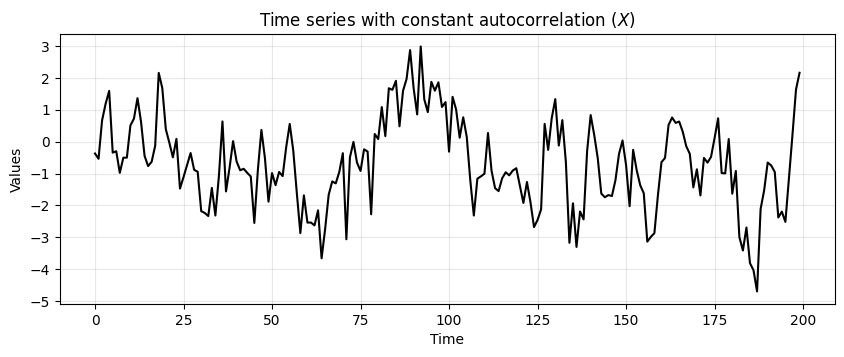

In [203]:
ar1 = np.array([1, -0.8])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
constant_autocorr_ts = AR_object1.generate_sample(nsample=200)

run_sequence_plot(time, constant_autocorr_ts, title="Time series with constant autocorrelation ($X$)");

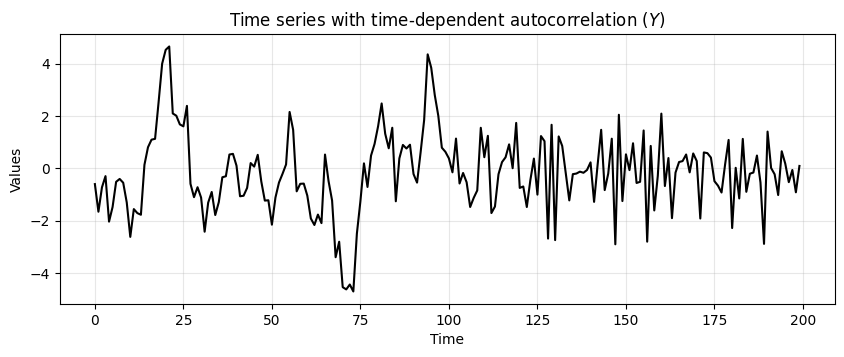

In [204]:
ar2 = np.array([1, -0.9])
AR_object2 = ArmaProcess(ar2, ma1)
ar3 = np.array([1, 0.3])
AR_object3 = ArmaProcess(ar3, ma1)

time_dependent_autocorr_ts_1 = AR_object2.generate_sample(nsample=100)
time_dependent_autocorr_ts_2 = AR_object3.generate_sample(nsample=100)
time_dependent_autocorr_ts = np.concatenate([time_dependent_autocorr_ts_1,
                                             time_dependent_autocorr_ts_2])

run_sequence_plot(time, time_dependent_autocorr_ts, title="Time series with time-dependent autocorrelation ($Y$)");

- Обратите внимание, как первая половина $Y$ показывает *более сильную автокорреляцию*.
- Каждое значение сильно зависит от своего непосредственного предшественника, что приводит к плавной и предсказуемой картине.

- Вторая часть характеризуется *более слабой автокорреляцией*.
- Временной ряд более нестабилен и меньше подвержен влиянию своих прошлых значений.

### Общие стационарные и нестационарные временные ряды

- Если аналитическое выражение временного ряда известно, можно проверить условия стационарности.
- На практике процесс генерации временного ряда может быть неизвестен, и нам понадобятся другие инструменты для проверки стационарности.
- Начало анализа с просмотра `run_sequence_plot` является отличной отправной точкой.

#### Белый шум

- Мы уже рассмотрели этот временной ряд и пришли к выводу, что среднее значение и дисперсия постоянны, а сезонная составляющая отсутствует.
- Кроме того, поскольку значение каждого временного шага вычисляется независимо, корреляции нет.

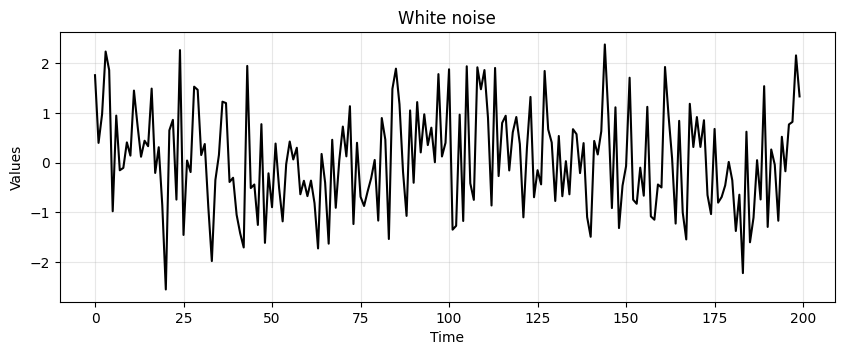

In [205]:
run_sequence_plot(time, stationary, title="White noise");

#### Случайное блуждание

- Случайное блуждание является одним из важнейших нестационарных временных рядов.
- Он определяется как:

$$X(t) = X(t-1) + \epsilon_t$$

- где $\epsilon_t$ называются *инновациями* и являются независимыми, например, $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$.
- Давайте создадим случайное блуждание.

In [206]:
# seed to start series
seed = 3.14

# Random Walk
rand_walk = np.empty_like(time, dtype='float')
for t in time:
    rand_walk[t] = seed + np.random.normal(loc=0, scale=2.5, size=1)[0]
    seed = rand_walk[t]

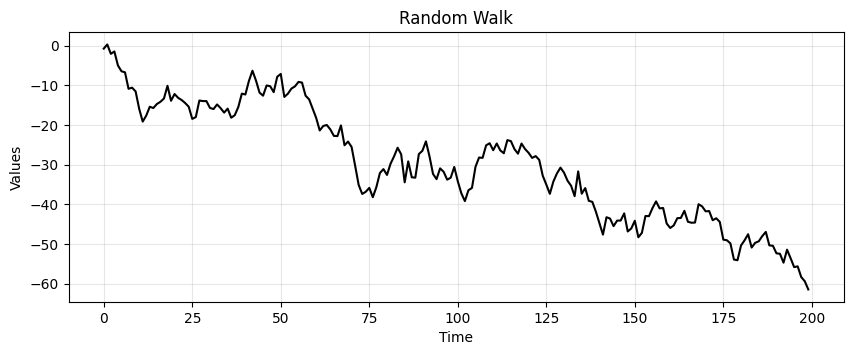

In [207]:
run_sequence_plot(time, rand_walk, title="Random Walk");

- Обратите внимание, как текущее значение сильно коррелирует с прошлыми значениями и колеблется гораздо меньше, чем белый шум.
- Случайное блуждание нестационарно.
- Почему 🤔?

**Зависимость от начального значения**

- Значение ряда в любой момент времени зависит от его начального значения и суммы всех предыдущих инноваций.
- Очевидно, что эта зависимость от пути означает нестационарность.

**Изменение дисперсии**

- При случайном блуждании дисперсия меняется со временем.
- Это нарушает условие №2 слабой стационарности.
- В частности, дисперсия *увеличивается* линейно с течением времени, поскольку эффекты инноваций накапливаются.
- Давайте рассмотрим это подробнее.

1. Мы начнем $t = 0$ и положим $X(0) = 0$ для простоты.

2. При $t = 1$ мы имеем:
   - $X(1) = X(0) + \epsilon_1$.
   - Дисперсия: $\text{Var}(X(1)) = \text{Var}(\epsilon_1) = \sigma^2$.

3. При $t = 2$ мы имеем:
   - $X(2) = X(1) + \epsilon_2 = X(0) + \epsilon_1 + \epsilon_2$.
   - Поскольку $\epsilon_1$ и $\epsilon_2$ независимы, мы получаем:
   
   $$\text{Var}(X(2)) = \text{Var}(\epsilon_1 + \epsilon_2) = \text{Var}(\epsilon_1) + \text{Var}(\epsilon_2) = \sigma^2 + \sigma^2 = 2\sigma^2$$

4. В общем случае $t$ мы имеем:
   - $X(t) = X(t-1) + \epsilon_t = X(0) + \epsilon_1 + \epsilon_2 + \ldots + \epsilon_t$.
   - Опять же, используя независимость $\epsilon$ и тот факт, что они имеют дисперсию $\sigma^2$ получаем:
   
   $$\text{Var}(X(t)) = \text{Var}(\epsilon_1) + \text{Var}(\epsilon_2) + \ldots + \text{Var}(\epsilon_t) = t\sigma^2$$

#### Временной ряд с тенденцией

- Рассмотрим следующие данные.

In [208]:
trend = (time * 2.75) + stationary

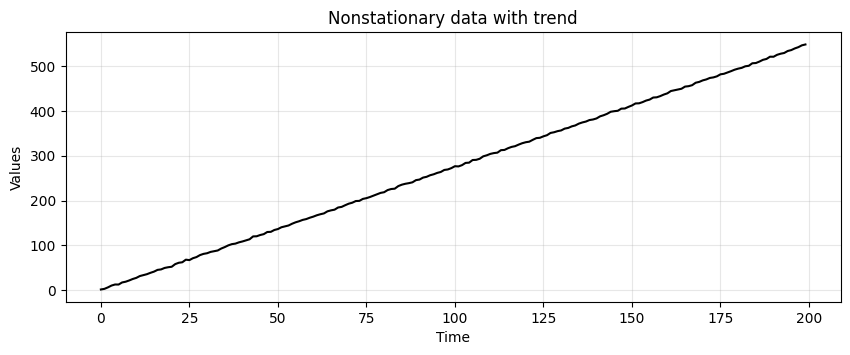

In [209]:
run_sequence_plot(time, trend, title="Nonstationary data with trend");

- Являются ли эти данные стационарными?

- Нет, среднее значение меняется со временем и нарушает условие №1.

#### Гетероскедастический временной ряд (Heteroscedastic time series)

In [210]:
level_1 = np.random.normal(loc=0, scale=1.0, size = 100)
level_2 = np.random.normal(loc=0, scale=10.0, size = 100)
heteroscedasticity = np.append(level_1, level_2)

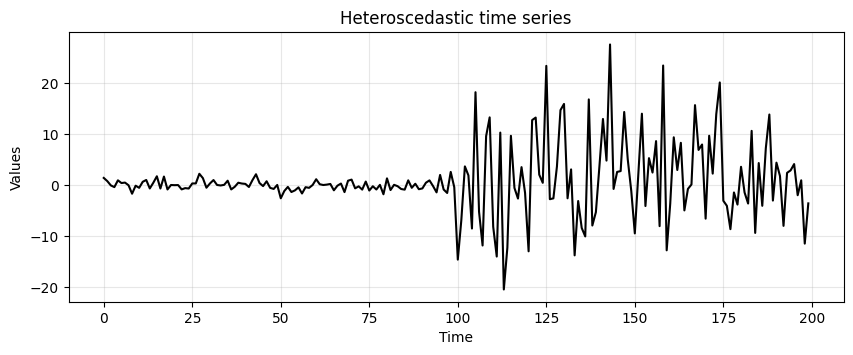

In [211]:
run_sequence_plot(time, heteroscedasticity, title="Heteroscedastic time series");

- Являются ли эти данные стационарными?

- Нет, дисперсия меняется со временем.

#### Временной ряд с сезонностью

In [212]:
seasonality = 20 + np.sin(2*np.pi*time/12)*20

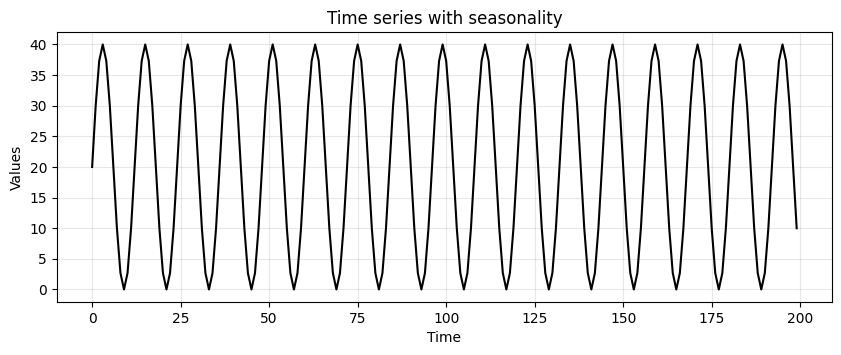

In [213]:
run_sequence_plot(time, seasonality, title="Time series with seasonality");

- Является ли этот временной ряд стационарным?

- Среднее значение периодического сигнала за полный цикл всегда принимает одно и то же значение (`20` в нашем случае).
- Однако в течение половины цикла или любого периода, не равного целому числу, кратному полному циклу, среднее значение изменяется (будет отличаться от `20`).
- Это нарушает условие №1.

<img src="data\l2\periodic_mean.png" style="width: 80%; display: block; margin: auto;">

#### Time series with trend and seasonality

In [214]:
trend_seasonality = trend + seasonality + stationary

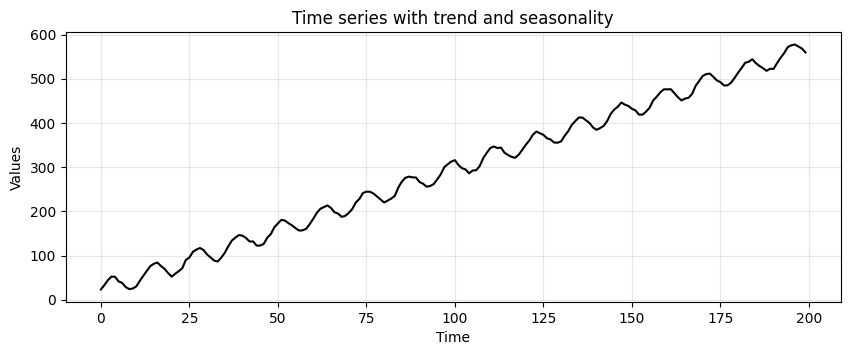

In [215]:
run_sequence_plot(time, trend_seasonality, title="Time series with trend and seasonality");

- Разве эти данные не стационарны?

- Нет, среднее значение меняется со временем из-за тенденции и присутствует периодическая составляющая.

#### Синусоидальный сигнал со случайной фазой

- Рассмотрим синусоидальный сигнал

$$X(t) = \mu + R \sin(\lambda t + \psi)$$

- где $\mu$ - среднее значение, $R$ - амплитуда, $\lambda$ - частота, а $\psi$ - фаза, равномерно распределенная в диапазоне $[- \pi, \pi]$.

- Это периодический сигнал?
- Удовлетворяет ли он условиям слабой стационарности?

- Из-за периодической и симметричной природы функции синуса, когда $\psi$ равномерно распределено по $[-\pi, \pi]$, каждое значение $\psi$, которое приводит к положительному значению, уравновешивается соответствующим значением $\psi$, которое приводит к отрицательному значению той же величины.
- Этот баланс означает, что $\mathbb{E}\big[ \sin(\lambda t + \psi) \big]=0$, поэтому:

$$
\begin{aligned}
\mathbb{E}[x_t]&=\mu + R~\mathbb{E}[\sin(\lambda t + \psi)]= \mu + 0 = \mu
\end{aligned}
$$

- **mean** $\mu + R \sin(\lambda t + \psi)$ равно $\mu$, что является константой.
- Условие №1 выполнено ✌
- Давайте также проверим его с помощью кода.

In [216]:
# Arbitrarily set the coefficients
R = 1.3
lamb = 3.5
t = 4

# Function to integrate
def func(psi):
    return R*np.sin(lamb*t + psi)

# Perform the numerical integration over the interval [-pi, pi]
mean, _ = quad(func, -np.pi, np.pi) # Change the interval to get an expectation != 0
print(mean)

7.847704120519421e-16


- **Дисперсия** случайной величины $X$, заданная как:

$$\text{Var}(X) = \mathbb{E}[X^2] - (\mathbb{E}[X])^2$$

- Давайте сначала рассмотрим $\sin(\lambda t + \psi)$, для которой мы знаем $\mathbb{E}[\sin(\lambda t + \psi)] = 0$
- Дисперсия упрощается до:

$$\text{Var}(\sin(\lambda t + \psi)) = \mathbb{E}[\sin^2(\lambda t + \psi)]$$

- Поскольку $\psi$ равномерно распределено по $[- \pi, \pi]$, то плотность распределения $\psi$ равна:

$$p(\psi) = \frac{1}{2\pi}$$

- Следовательно, дисперсия $\sin^2(\lambda t + \psi)$ равна:

\begin{align*}
\mathbb{E}[\sin^2(\lambda t + \psi)] & = \int_{-\pi}^{\pi} \sin^2(\lambda t + \psi) p(\psi) d\psi\\
&= \frac{1}{2\pi} \int_{-\pi}^{\pi} \sin^2(\lambda t + \psi) d\psi
\end{align*}

- Для любого $x$ имеем, что $\int_{-\pi}^{\pi} \sin^2(x) dx = \pi$

<img src="data\l2\int.png" style="width: 40%; display: block; margin: auto;">

- Это дает нам:

$$\text{Var}(\sin(\lambda t + \psi)) = \mathbb{E}[\sin^2(\lambda t + \psi)] = \frac{1}{2\pi}\pi = \frac{1}{2}$$

- Легко видеть, что $\text{Var}[\mu + R\sin(\lambda t + \psi)]$ равно $\frac{R^2}{2}$.
- Мы заключаем, что дисперсия конечна и постоянна.
- Также выполняется условие №2 ✌

In [217]:
R = 3
lamb = 6.5
t = 4

def func_sin2(psi):
    return ((R*np.sin(lamb*t + psi))**2) / (2*np.pi)

# Perform the numerical integration
variance, _ = quad(func_sin2, -np.pi, np.pi)
print(variance)

4.5


- Функция автоковариации для лага $h$ определяется как:

$$\text{Cov}(X(t), X(t+h)) = \mathbb{E}[(X(t) - \mu)(X(t+\tau) - \mu)]$$

- Так как $X(t) = \mu + R \sin(\lambda t + \psi)$,автоковариация становится:

$$\text{Cov}(X(t), X(t+h)) = \mathbb{E}\left[\left(R \sin(\lambda t + \psi)\right)\left(R \sin(\lambda (t + \tau) + \psi)\right)\right]$$

$$= R^2 \mathbb{E}\left[\sin(\lambda t + \psi) \sin(\lambda (t + \tau) + \psi)\right]$$

- Теперь используем тригонометрическое тождество:

$$\sin(A) \sin(B) = \frac{1}{2}[\cos(A - B) - \cos(A + B)]$$

- Применяя это тождество, получаем:

\begin{align*}
\text{Cov}(x_t, x_{t+h}) & = R^2 \mathbb{E}\left[\frac{1}{2}[\cos(\lambda t + \psi - \lambda (t + h) - \psi) - \cos(\lambda t + \psi + \lambda (t + h) + \psi)]\right]\\
& = \frac{R^2}{2} \mathbb{E}\left[\cos(\lambda h) - \cos(2\lambda t + 2\psi + \lambda h)\right]\\
& = \frac{R^2}{2} \mathbb{E}\left[\cos(\lambda h)\right] - \frac{R^2}{2} \mathbb{E}\left[\cos(2\lambda t + 2\psi + \lambda h)\right] \end{align*}

- Ожидание берется по случайной величине $\psi$.
- Следуя тем же рассуждениям, что и для среднего значения, $\cos(2\lambda t + 2\psi + \lambda \tau)$ в среднем равно нулю, поскольку $\psi$ равномерно распределено по $[- \pi, \pi]$.
- Таким образом:

$$\text{Cov}(x_t, x_{t+h}) = \frac{R^2}{2} \cos(\lambda h)$$

- Таким образом, функция автоковариации зависит только от лага $h$ и *независима* от времени $t$.
- Также выполняется условие №3 ✌.

В заключение, временной ряд $X(t) = \mu + R \sin(\lambda t + \psi)$ является слабо стационарным:

- его среднее значение постоянно,
- его дисперсия постоянна,
- его автоковариация зависит только от лага $h$.

Как выглядит $X(t) = \mu + R \sin(\lambda t + \psi)$?

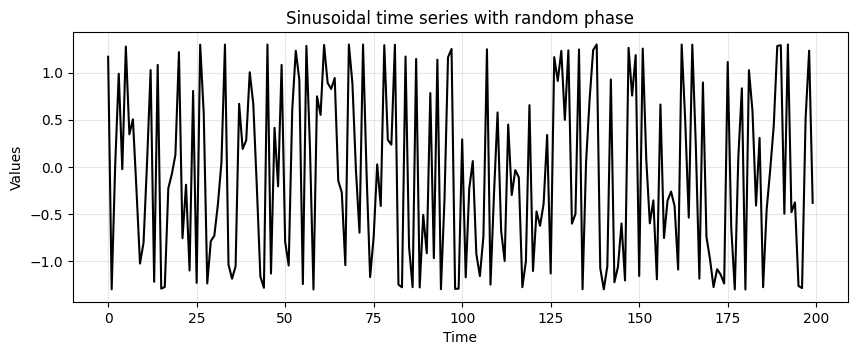

In [218]:
R = 1.3
lamb = 3.5
phi = np.random.uniform(-np.pi, np.pi, len(time))
cyc = R * np.sin(lamb * time + phi)
run_sequence_plot(time, cyc, title="Sinusoidal time series with random phase");

**📨 Вывод**
- Временной ряд, полученный из периодической функции, может быть слабо стационарным.
- Наличие периодических функций явно не указано в 3 условиях.
- Будьте осторожны при определении слабой стационарности на основе периодических компонентов.

---

## Обнаружение стационарности

Далее мы рассмотрим практические методы, используемые для определения того, является ли временной ряд стационарным или нет.

В частности, мы рассмотрим:
1. Графики последовательности выполнения (Run-sequence plot)
2. Сводные статистики
3. Расширенный тест Дики-Фуллера

### Графики последовательности выполнения

- Графики последовательности выполнения позволяют визуализировать то, что происходит с данными.
- Это всегда должно быть вашей отправной точкой.
- Действительно, это то, что мы делали до сих пор с нашей функцией `run_sequence_plot`.
- Она часто показывает, есть ли базовая структура.
- Будьте внимательны к тренду, сезонности и автокорреляции.

### Сводная статистика (Summary Statistics)

- Простой способ проверки постоянного среднего значения и дисперсии — разбить данные на отдельные фрагменты.
- Затем вычисляется статистика для каждого фрагмента и сравнивается.
- Большие отклонения либо в среднем значении, либо в дисперсии между фрагментами могут указывать на то, что временной ряд нестационарен.
- Это не строгий метод, но он дает хорошее представление о том, являются ли данные приблизительно стационарными или нет.

Вот как выглядит стационарный временной ряд.

<img src="data\l2\stationary_chunk.png" style="width: 45%; display: block; margin: auto;">

Вот как выглядит нестационарный временной ряд.

<img src="data\l2\nonstationary_chunk.png" style="width: 45%; display: block; margin: auto;">

- Давайте рассмотрим пример, основанный на временном ряде «тренда», который мы создали ранее.

In [219]:
# split data into 10 chunks
chunks = np.split(trend, indices_or_sections=10)

Summary statistics:

In [220]:
print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
print("-" * 35)
for i, chunk in enumerate(chunks, 1):
    print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunk), np.var(chunk)))

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 26.694	 | 241.23
 2	 | 81.181	 | 255.62
 3	 | 135.73	 | 258.47
 4	 | 190.77	 | 257.08
 5	 | 246.55	 | 257.82
 6	 | 301.62	 | 259.15
 7	 | 356.19	 | 249.28
 8	 | 411.09	 | 244.11
 9	 | 466.14	 | 245.37
10	 | 520.99	 | 275.11


- Хотя дисперсия относительно постоянна с течением времени, среднее значение явно меняется, что означает, что эти данные не являются стационарными.
- Мы ожидаем некоторые колебания значений.
- Маловероятно, что среднее значение и дисперсия будут абсолютно одинаковыми во всех фрагментах, но они должны быть близки.

- Чтобы лучше это увидеть, неплохо построить график средних значений и дисперсий.
- Если вы хотите быть более точными, вы можете провести статистический тест, чтобы определить, является ли разница в средних значениях или разница в дисперсиях статистически значимой.

### Расширенный тест Дики-Фуллера (augmented Dickey–Fuller test (ADF) )

- Это статистическая процедура для определения того, является ли временной ряд стационарным или нет.
- Мы обсудим тест более подробно на следующих лекциях.
- На данный момент нам нужно знать следующее:
1. **Нулевая гипотеза:** $H_0$: ряд нестационарный.
2. **Альтернативная гипотеза:** $H_A$: ряд стационарный.

- Как и в любом статистическом тесте, вам следует установить уровень значимости или порог, который определяет, следует ли вам принять или отвергнуть ноль.
- Значения $\alpha=0,05$ или $\alpha=0,01$, которые дают достоверность $95\%$ и $99\%$ соответственно, являются обычным выбором.

Пример: $p = 0,0001 \rightarrow$ отвергаем $H_0 \rightarrow$ временной ряд стационарен

Пример: $p = 0,43 \rightarrow$ не удается отвергнуть $H_0 \rightarrow$ временной ряд нестационарен

 Тест ADF может быть неточным при небольших наборах данных или при наличии гетероскедастичности.
- Лучше всего сочетать ADF с другими методами (графиками последовательности запусков, сводной статистикой, гистограммами и т. д.).

#### Стационарные данные и ADF

- Давайте посмотрим, как запустить этот тест на Python.

In [221]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(stationary)

- Давайте рассмотрим и прокомментируем основные результаты теста ADF.

In [222]:
print(f"ADF: {adf:.2f}")

ADF: -13.56


- Во-первых, `adf` - это значение тестовой статистики.
- Чем отрицательнее значение, тем больше мы можем быть уверены в том, что ряд стационарен.
- Здесь мы видим отрицательное значение.
- Это может пока ничего вам не говорить, но `pvalue` должно.

In [223]:
print(f"p-value: {pvalue}")

p-value: 2.3001721380706884e-25


 - `pvalue` интерпретируется как любое p-значение.
- `pvalue` следует сравнивать с уровнями достоверности (например, $\alpha=0.05$ или $\alpha=0.01$).
- На основе сравнения мы отклоняем или не отклоняем $H_0$.
- Здесь ``pvalue`` очень близко к нулю, поэтому мы **отвергаем** $H_0$ в пользу $H_A$ и делаем вывод, что временной ряд является стационарным.

In [224]:
print(f"nobs: {nobs}")

nobs: 199


- Переменная `nobs` — это просто количество наблюдений во временном ряду.

In [225]:
print(f"critical values: {critical_values}")

critical values: {'1%': np.float64(-3.4636447617687436), '5%': np.float64(-2.8761761179270766), '10%': np.float64(-2.57457158581854)}


- Наконец, ``critical_values`` - это пороговые значения тестовой статистики для общих значимых уровней.
- Здесь мы видим, что тестовая статистика ниже -2,87 достаточна для отклонения $H_0$ на уровне значимости 5%.

- Вы могли заметить два вывода, которые мы не обсудили.
- Смотрите [statsmodels docs](http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) для описания ``usedlag`` и ``icbest``.

#### ADF на временных рядах с трендом
- Далее мы запускаем тест ADF на временных рядах `тренда`.

In [226]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(trend, regression='c')
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: 0.82
p-value: 0.992


- Как и ожидалось, нам не удалось отвергнуть гипотезу $H_0$ о том, что временной ряд `тренда` является нестационарным.

### ADF on random walk  (ADF на случайном блуждании)

- Наконец, мы запускаем тест ADF на временном ряду `rand_walk`.

In [227]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(rand_walk, regression='c')
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: -1.03
p-value: 0.741


- Как мы уже обсуждали, случайное блуждание нестационарно, поскольку его дисперсия $\sigma^2t$ не постоянна во времени.
- В следующем разделе мы узнаем, как сделать этот временной ряд стационарным.

- Хорошие новости 😎. На данный момент в нашем распоряжении есть несколько инструментов, позволяющих выяснить, является ли временной ряд стационарным или нет.

---

## Общие преобразования для достижения стационарности

- Существует несколько способов преобразования нестационарных временных рядов:

Преобразование | Эффект
:---|:---
Вычитание тренда | Постоянное среднее
Применение логарифма | Постоянная дисперсия
Дифференцирование | Удаление автокорреляции
Сезонная дифференциация | Удаление периодической составляющей

- Часто вам придется делать несколько из этого с одним набором данных.
- Обратите внимание, что это всего лишь небольшое подмножество всех возможных способов преобразования нестационарных временных рядов.

### Вычтите предполагаемую тенденцию и сезонность

- Давайте проведем тест ADF перед трансформацией.

In [228]:
adf_b4, pvalue_b4, _, _, _, _ = adfuller(trend_seasonality)
print(f"ADF: {adf_b4:.2f}")
print(f"p-value: {pvalue_b4:.3f}")

ADF: 1.01
p-value: 0.994


- Нестационарно, как и ожидалось.
- Далее применяем преобразование.

In [229]:
ss_decomposition = seasonal_decompose(x=trend_seasonality, model='additive', period=12)
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_residual = ss_decomposition.resid

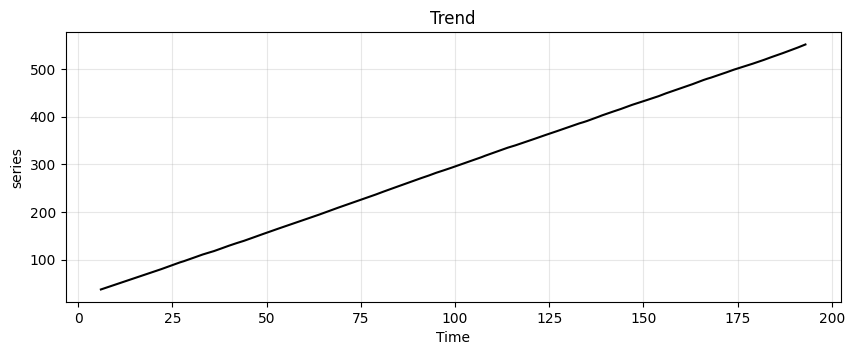

In [230]:
run_sequence_plot(time, est_trend, title="Trend", ylabel="series");

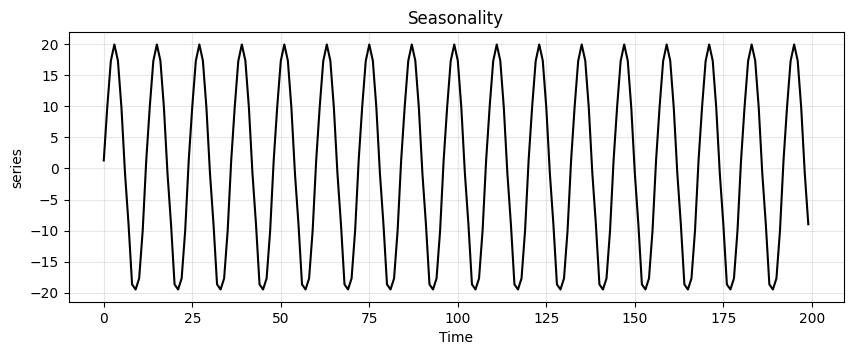

In [231]:
run_sequence_plot(time, est_seasonal, title="Seasonality", ylabel="series");

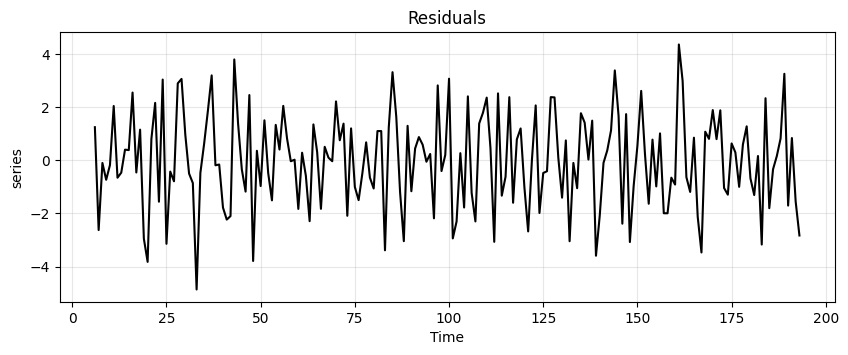

In [232]:
run_sequence_plot(time, est_residual, title="Residuals", ylabel="series");

- Давайте посмотрим на остаточные значения.

In [233]:
print(est_residual)

[        nan         nan         nan         nan         nan         nan
  1.24368173 -2.62651313 -0.10234455 -0.73531189 -0.1829664   2.04130761
 -0.65755141 -0.46722156  0.39903068  0.38172731  2.54722749 -0.46031003
  1.15158029 -2.95123128 -3.8243952   0.80129202  2.15850427 -1.56043208
  3.0359116  -3.14443182 -0.42647195 -0.79241057  2.89305425  3.06029956
  0.96135096 -0.50108732 -0.85817676 -4.86262436 -0.47675426  0.62469458
  1.86733165  3.19296905 -0.18983981 -0.16068445 -1.78136305 -2.23271451
 -2.10183683  3.79310173  1.39263034 -0.34341253 -1.17970353  2.45314096
 -3.79055414  0.35619929 -0.97123041  1.50295994 -0.48073187 -1.50897278
  1.33062156  0.40333605  2.04519325  0.82223149 -0.03721313  0.02072604
 -1.83124467  0.28260905 -0.58713007 -2.29219567  1.34745638  0.30238082
 -1.82829117  0.50552599  0.09712559 -0.03657677  2.21367333  0.75259989
  1.3771748  -2.08987195  1.19900202 -1.00537537 -1.50116216 -0.48861264
  0.67380781 -0.65481532 -1.06292965  1.09813623  1

- Нам придется удалить первые $6$ и последние $6$ значения, чтобы запустить тест ADF, так как они `nan`.
- Число 6 связано с тем, что метод применяет сезонную дифференциацию, а мы указали `period=12`.
- Вот как это сделать и запустить тест за один вызов.

In [234]:
adf_after, pvalue_after, _, _, _, _ = adfuller(est_residual[6:-6])
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -6.61
p-value: 0.000


- Теперь временной ряд стационарен ✌.

### Стабилизация дисперсии с помощью логарифмического преобразования

- Этот прием полезен при работе с гетероскедастическими данными.
- Логарифм сжимает части временного ряда, где дисперсия выше.
- Таким образом, дисперсия становится более однородной.
- Давайте снова построим график гетероскедастического временного ряда, чтобы запомнить, как он выглядит.

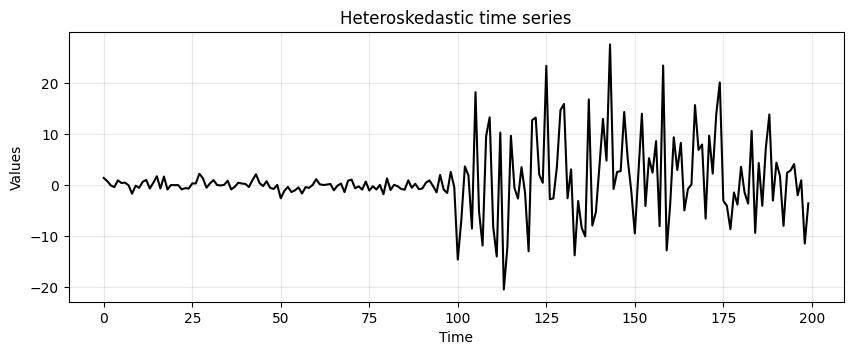

In [235]:
run_sequence_plot(time, heteroscedasticity, title="Heteroskedastic time series");

- Let's run the ADF test.

In [236]:
adf_b4, pvalue_b4, _, _, _, _ = adfuller(heteroscedasticity)
print(f"ADF: {adf_b4:.2f}")
print(f"p-value: {pvalue_b4:.3f}")

ADF: -2.49
p-value: 0.118


**⚠ Внимание**

- ADF говорит, что мы отвергаем $H_0$ (по крайней мере на уровне достоверности $\alpha=0.05$) в пользу альтернативы, что временной ряд является стационарным.
- Однако график ясно показывает, что дисперсия не является постоянной во времени.

- Это важный урок.
- Некоторые статистические тесты, такие как ADF, работают плохо в некоторых ситуациях:
- при небольшом количестве данных,
- когда данные гетероскедастичны.

- Давайте теперь применим логарифмическое преобразование.
- Перед этим мы вычитаем минимум и добавляем небольшую константу
- Таким образом мы гарантируем, что все значения будут положительными

In [237]:
# Ensure all data are positive
new_hetero = heteroscedasticity - heteroscedasticity.min() + 1.0

# Apply the log
log_new_hetero = np.log(new_hetero)

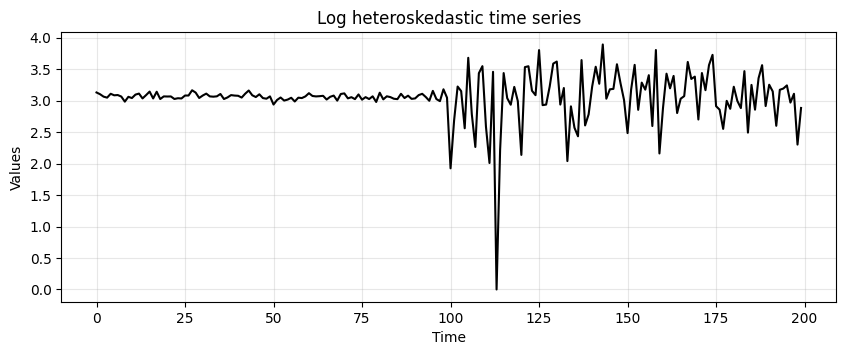

In [238]:
run_sequence_plot(time, log_new_hetero, title="Log heteroskedastic time series");

- Посмотрите на значения на оси $y$.
- Обратите внимание, как сильно сократилась дисперсия.

📨 Вывод:

- Тест ADF может не обнаружить нестационарность из-за гетероскедастичности.
- Всегда отображайте данные на графике.
- Не полагайтесь на один инструмент для определения стационарности.

### Удаление автокорреляции с помощью дифференциации

- Помните, что тест ADF (правильно) указал, что временной ряд `rand_walk` нестационарен.
- Мы можем преобразовать `rand_walk` в стационарный временной ряд, применив дифференциацию.
- Это делается путем вычитания прошлого значения из текущего значения.

- Мы знаем, что `rand_walk` был создан с задержкой 1.
- Таким образом, стационарный временной ряд может быть получен как:

$$\hat{X}(t) = X(t) - X(t-1)$$

In [239]:
difference = rand_walk[:-1] - rand_walk[1:]

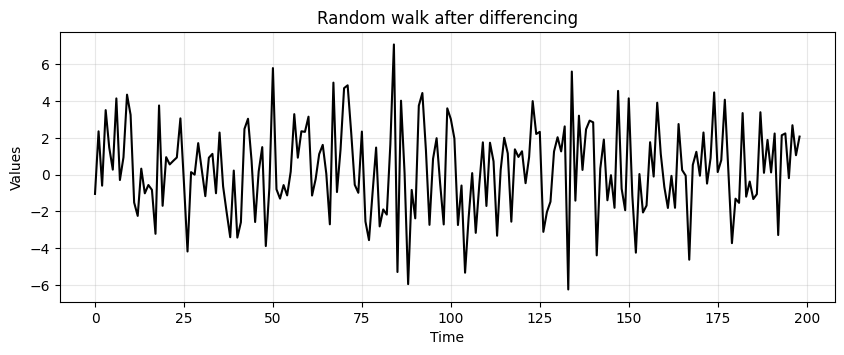

In [240]:
run_sequence_plot(time[:-1], difference, title="Random walk after differencing");

- Let's run ADF on the differenced data.

In [241]:
adf_after, pvalue_after, _, _, _, _ = adfuller(difference)
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -14.60
p-value: 0.000


Стационарный!

- Давайте рассмотрим другой пример.
- Мы создаем небольшой фрейм данных от 1 до 10 (линейный и квадратный).

In [242]:
df = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
df.columns = ['original', 'squared']
df

,original,squared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


- Сделайте первый временной ряд (``исходный``) стационарным, чтобы среднее значение и дисперсия не менялись для подокна.

In [243]:
df.original.diff().to_frame("1st order difference")

,1st order difference
0,NaN
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


**💡 ПРИМЕЧАНИЕ:** Это похоже на взятие производной первого порядка.

In [244]:
df.squared.diff().diff().to_frame("2nd order difference")

,2nd order difference
0,NaN
1,NaN
2,2.0
3,2.0
4,2.0
5,2.0
6,2.0
7,2.0
8,2.0
9,2.0


- Обратите внимание, что нам нужно дважды дифференцировать экспоненциальный временной ряд.
- Каждый раз, когда мы делаем дифференцирование, мы теряем часть данных.

- Мы также можем попытаться сделать второй временной ряд стационарным с помощью логарифма.

In [245]:
np.log(df.squared).to_frame("log")

,log
0,0.000000
1,1.386294
2,2.197225
3,2.772589
4,3.218876
5,3.583519
6,3.891820
7,4.158883
8,4.394449
9,4.605170


- Работает как-то, но, конечно, не так хорошо, как дифференцирование

- В общем случае мы не знаем оптимального лага для выполнения дифференциации.
- Как определить оптимальный порядок дифференциации, будет рассмотрено позже.

### Сезонная дифференциация

- Рассмотрим временной ряд с сезонностью периода $L$.
- Будет сильная корреляция между $X(t)$ и $X(t+L)$.
- Сезонная дифференциация может устранить сезонность и сделать временной ряд стационарным:

$$\hat{X}(t) = X(t+L) - X(t)$$

- После сезонной дифференциации временной ряд станет на $L$ шагов короче.
- Обратите внимание, что мы можем выполнить стандартную дифференциацию каскадом к сезонной дифференциации, если нам нужно удалить также тренд поверх сезонности.
- Давайте посмотрим на это на временном ряду `trend_seasonality`.

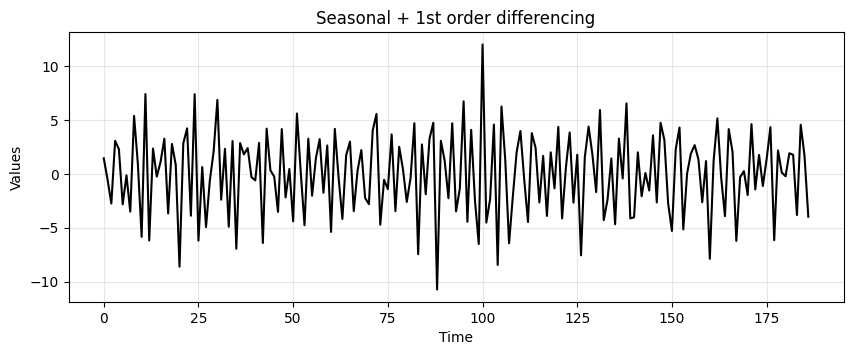

In [246]:
trend_seasonality_d12 = trend_seasonality[:-12] - trend_seasonality[12:] # remove seasonality
trend_seasonality_d12_d1 = trend_seasonality_d12[:-1] - trend_seasonality_d12[1:] # remove trend

# Plot the differenced time series
run_sequence_plot(time[:-13], trend_seasonality_d12_d1, title="Seasonal + 1st order differencing");

In [247]:
adf_after, pvalue_after, _, _, _, _ = adfuller(trend_seasonality_d12_d1)
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -5.28
p-value: 0.000


---

## Резюме

В этой лекции мы узнали:
1. Что означает, что временной ряд является стационарным.
2. Набор известных стационарных и нестационарных временных рядов.
2. Общие инструменты для определения стационарности.
3. Полезные преобразования нестационарного в стационарное.

## Exercises

### Упражнение 1

- Загрузите два временных ряда `stationarity_ts1` и `stationarity_ts2`, выполнив код ниже.

In [248]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts1.npy?download=1")
response.raise_for_status()
stationarity_ts1 = np.load(BytesIO(response.content))
print(len(stationarity_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts2.npy?download=1")
response.raise_for_status()
stationarity_ts2 = np.load(BytesIO(response.content))
print(len(stationarity_ts2))

100
100


1. Постройте два временных ряда с помощью графика последовательности запусков.
4. На основе графика обсудите, является ли каждый временной ряд стационарным или нет.

In [249]:
time1 = np.arange(len(stationarity_ts1))
time2 = np.arange(len(stationarity_ts2))

<Axes: title={'center': 'stationarity_ts1'}, xlabel='Time', ylabel='Values'>

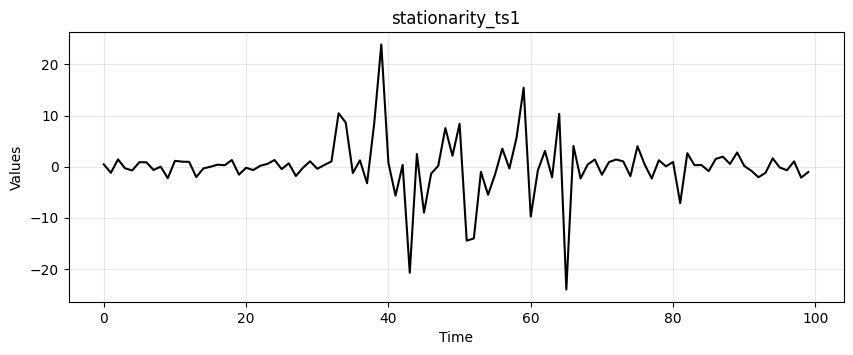

In [250]:
run_sequence_plot(time1, stationarity_ts1, title="stationarity_ts1")

Ряд нестационарный из-за скачущей дисперсии

<Axes: title={'center': 'stationarity_ts2'}, xlabel='Time', ylabel='Values'>

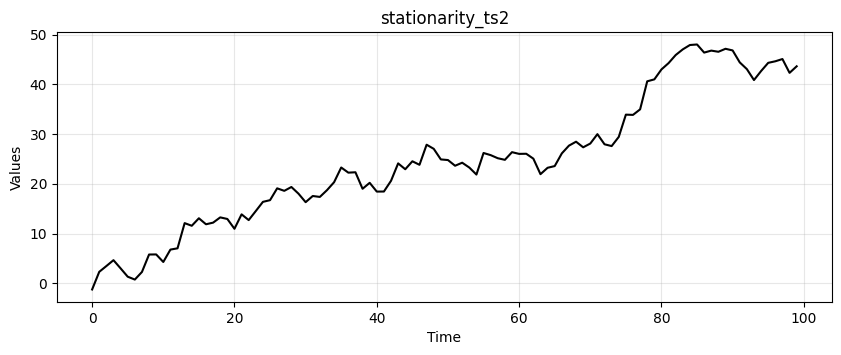

In [251]:
run_sequence_plot(time1, stationarity_ts2, title="stationarity_ts2")

Непостоянный ренд, ряд нестационарный

In [252]:

from scipy.fft import fft

def fft_analysis(signal):

    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")

    return dominant_period, positive_frequencies, magnitudes



In [253]:
period, freqs, magnitudes = fft_analysis(stationarity_ts2)

Dominant Frequency: 0.020
Dominant Period: 50.00 time units


### Упражнение 2

Используйте следующие инструменты, чтобы определить, являются ли временные ряды `stationarity_ts1` и `stationarity_ts2` стационарными или нет.

1. Сводная статистика по фрагментам.
2. Гистограммы.
3. Расширенный тест Дики-Фуллера.

Обсудите результат, полученный с помощью каждого метода.

In [254]:
from tabulate import tabulate
# split data into 10 chunks
chunks1 = np.split(stationarity_ts1, indices_or_sections=10)
chunks2 = np.split(stationarity_ts2, indices_or_sections=10)

Сводная статистика по первому и второму ряду

In [255]:
# Создаём список списков для tabulate
table_data = []
for i, chunk in enumerate(chunks1, 1):
    table_data.append([
        i,
        np.mean(chunk),
        np.var(chunk)
    ])

# Заголовки столбцов
headers = ["Chunk", "Mean", "Variance"]

# Выводим таблицу
print(tabulate(table_data, headers=headers, floatfmt=".5f", tablefmt="github"))

|   Chunk |     Mean |   Variance |
|---------|----------|------------|
|       1 | -0.14368 |    1.10649 |
|       2 |  0.12109 |    1.16522 |
|       3 |  0.04715 |    0.76635 |
|       4 |  4.92083 |   59.91993 |
|       5 | -2.32627 |   55.94682 |
|       6 | -0.37065 |   79.16835 |
|       7 | -1.95085 |   77.81561 |
|       8 |  0.34635 |    3.18839 |
|       9 |  0.30483 |    7.29303 |
|      10 | -0.51908 |    1.34695 |


In [256]:
# Создаём список списков для tabulate
table_data = []
for i, chunk in enumerate(chunks2, 1):
    table_data.append([
        i,
        np.mean(chunk),
        np.var(chunk)
    ])

# Заголовки столбцов
headers = ["Chunk", "Mean", "Variance"]

# Выводим таблицу
print(tabulate(table_data, headers=headers, floatfmt=".5f", tablefmt="github"))

|   Chunk |     Mean |   Variance |
|---------|----------|------------|
|       1 |  2.81862 |    4.50258 |
|       2 | 10.51083 |    9.30344 |
|       3 | 16.02253 |    7.51911 |
|       4 | 19.73252 |    4.97895 |
|       5 | 23.26775 |    9.42708 |
|       6 | 24.60790 |    1.77172 |
|       7 | 25.54324 |    3.96080 |
|       8 | 32.73578 |   22.71299 |
|       9 | 46.28943 |    2.22467 |
|      10 | 43.77349 |    2.47820 |


Гистограммы

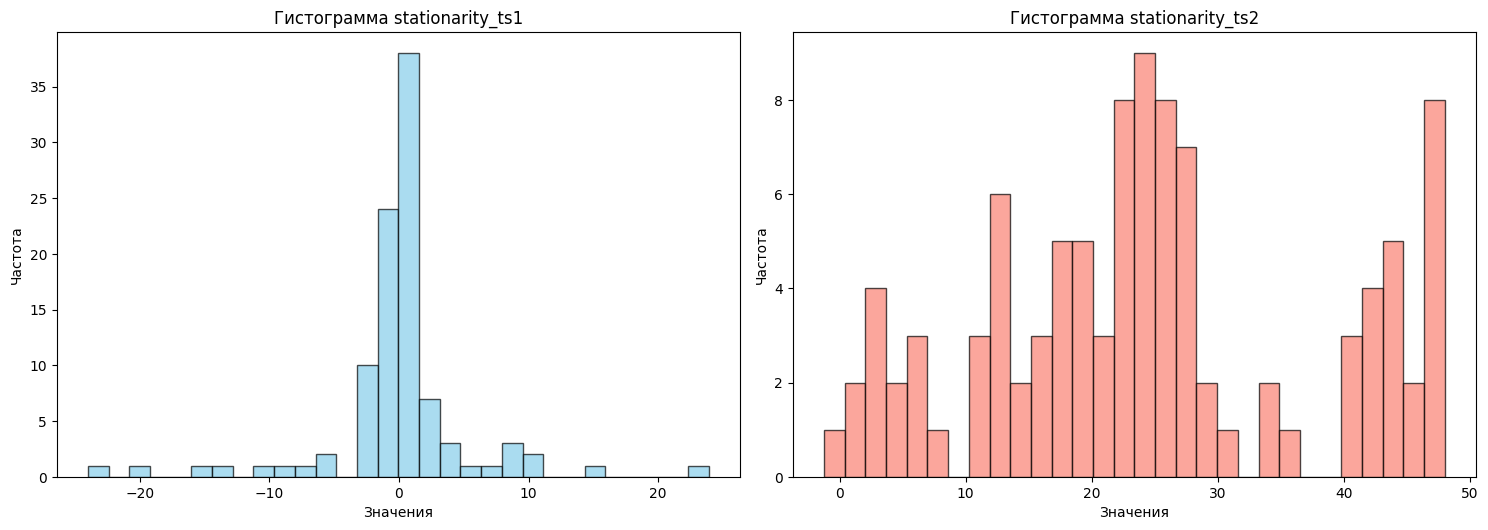

In [276]:
plt.figure(figsize=(15, 10))
    
    # Гистограммы распределения
plt.subplot(2, 2, 1)
plt.hist(stationarity_ts1, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f'Гистограмма stationarity_ts1')
plt.xlabel('Значения')
plt.ylabel('Частота')
    
plt.subplot(2, 2, 2)
plt.hist(stationarity_ts2, bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.title(f'Гистограмма stationarity_ts2')
plt.xlabel('Значения')
plt.ylabel('Частота')
    
plt.tight_layout()
plt.show()

Взглядя на эти гистограммы, можно сказать, что отсутсвует стационарность

In [272]:
adf, pvalue, _, _, _, _ = adfuller(stationarity_ts1)
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: -3.03
p-value: 0.032


Ряд слабо стационарен, потому что adf не учитывает дисперсию

In [273]:
adf, pvalue, _, _, _, _ = adfuller(stationarity_ts2)
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: -1.32
p-value: 0.619


Второй ряд не стационарен

### Упражнение 3
Если один или оба набора данных из упражнений не являются нестационарными, примените преобразования, которые вы изучили в этом разделе, чтобы сделать их таковыми. Затем примените методы, которые вы изучили, чтобы обеспечить стационарность.

In [262]:
# Ensure all data are positive
new_hetero_stationarity_ts1 = stationarity_ts1 - stationarity_ts1.min() + 1.0

# Apply the log
log_new_hetero_stationarity_ts1 = np.log(new_hetero_stationarity_ts1)

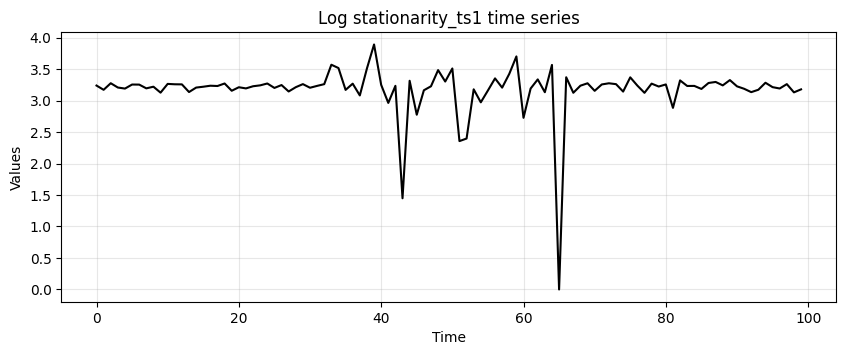

In [263]:
run_sequence_plot(time1, log_new_hetero_stationarity_ts1, title="Log stationarity_ts1 time series");

In [264]:
adf, pvalue, _, _, _, _ = adfuller(log_new_hetero_stationarity_ts1)
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: -10.75
p-value: 0.000


In [265]:
chunks1_stat = np.split(log_new_hetero_stationarity_ts1, indices_or_sections=10)

In [266]:
# Создаём список списков для tabulate
table_data = []
for i, chunk in enumerate(chunks1_stat, 1):
    table_data.append([
        i,
        np.mean(chunk),
        np.var(chunk)
    ])

# Заголовки столбцов
headers = ["Chunk", "Mean", "Variance"]

# Выводим таблицу
print(tabulate(table_data, headers=headers, floatfmt=".5f", tablefmt="github"))

|   Chunk |    Mean |   Variance |
|---------|---------|------------|
|       1 | 3.21239 |    0.00183 |
|       2 | 3.22294 |    0.00192 |
|       3 | 3.22032 |    0.00125 |
|       4 | 3.36967 |    0.05439 |
|       5 | 3.01547 |    0.30753 |
|       6 | 3.12498 |    0.17748 |
|       7 | 2.89507 |    0.97331 |
|       8 | 3.23035 |    0.00492 |
|       9 | 3.22446 |    0.01461 |
|      10 | 3.19697 |    0.00222 |


In [267]:
difference_ts2 = stationarity_ts2[:-1] - stationarity_ts2[1:]

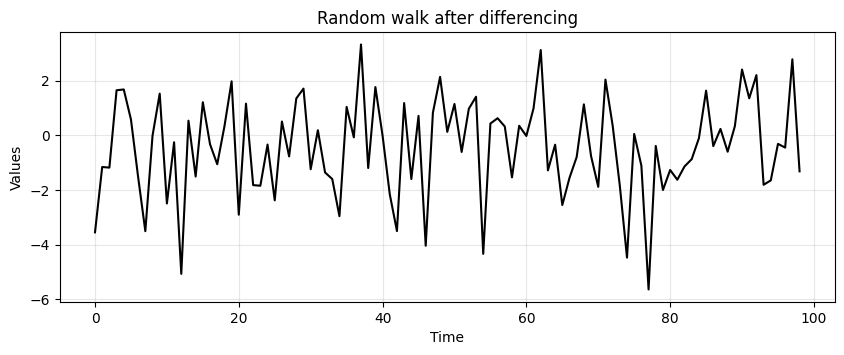

In [268]:
run_sequence_plot(time2[:-1], difference_ts2, title="Random walk after differencing");

In [269]:
adf, pvalue, _, _, _, _ = adfuller(difference_ts2)
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: -10.28
p-value: 0.000


In [270]:
chunks2_stat = np.split(difference_ts2, indices_or_sections=9)

In [271]:
# Создаём список списков для tabulate
table_data = []
for i, chunk in enumerate(chunks2_stat, 1):
    table_data.append([
        i,
        np.mean(chunk),
        np.var(chunk)
    ])

# Заголовки столбцов
headers = ["Chunk", "Mean", "Variance"]

# Выводим таблицу
print(tabulate(table_data, headers=headers, floatfmt=".5f", tablefmt="github"))

|   Chunk |     Mean |   Variance |
|---------|----------|------------|
|       1 | -0.72870 |    3.49815 |
|       2 | -0.53902 |    3.77394 |
|       3 | -0.54679 |    1.65347 |
|       4 | -0.38227 |    4.05401 |
|       5 | -0.29692 |    4.27487 |
|       6 |  0.00731 |    2.01011 |
|       7 | -0.80460 |    2.74966 |
|       8 | -1.05204 |    2.99322 |
|       9 |  0.26540 |    2.53348 |


Вывод по третьему упражнению: 

Сделали ряды стационарными